In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clear cache log
#get_ipython().run_line_magic('reset', '')

# Remove saved weights
import os
import shutil
if os.path.exists('checkpoint.pth'):
    os.remove('checkpoint.pth')
    print("Saved weights removed.")
else:
    print("No saved weights found.")

# Clear any other temporary files or directories
shutil.rmtree('/content/__pycache__', ignore_errors=True)
print("Cache cleared.")

No saved weights found.
Cache cleared.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
import math
import copy
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import time

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class LinearLayer(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(LinearLayer, self).__init__()
        self.linear = nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(inplace=True))

    def forward(self, x):
        x = self.linear(x)
        return x

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# **Transformer Architecture**

**Positional Encoding**

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, seq_length):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        #Create matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_length, d_model)
        #Create a vector of shape (seq_len,1)
        position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        #Apply the sine to even position(every vector will have sine only in the even position)
        pe[:, 0::2] = torch.sin(position * div_term)
        #Apply the cosine to even position(every vector will have cosine only in the even position)
        pe[:, 1::2] = torch.cos(position * div_term)


        self.register_buffer('pe', pe.unsqueeze(0)) # pe shape (1, seq_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [ ]:
class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

In [ ]:
class TemporalEmbedding(nn.Module):
    def __init__(self, d_model):
        super(TemporalEmbedding, self).__init__()

        hours = 24
        weekdays = 7
        months = 13
        weeks = 54

        Embed = FixedEmbedding

        self.hour_embed = Embed(hours, d_model)
        self.weekday_embed = Embed(weekdays, d_model)
        self.week_embed = Embed(weeks, d_model)
        self.month_embed = Embed(months, d_model)

    def forward(self, x):
        x = x.long()

        hour_x = self.hour_embed(x[:,:,3])
        weekday_x = self.weekday_embed(x[:,:,4])
        week_x = self.week_embed(x[:,:,2])
        month_x = self.month_embed(x[:,:,1])

        return hour_x + weekday_x + week_x + month_x

In [ ]:
class DataEmbedding(nn.Module):
    def __init__(self, d_model, seq_length, dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.position_embedding = PositionalEncoding(d_model, seq_length)
        self.temporal_embedding = TemporalEmbedding(d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.position_embedding(x) + self.temporal_embedding(x_mark)

        return self.dropout(x)


**Layer Normalization**

In [ ]:
class LayerNormalization(nn.Module):

    def __init__(self, eps:float = 10**-6):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1)) #multiplied
        self.bias = nn.Parameter(torch.zeros(1)) #added

    def forward(self,x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)
        return self.alpha * ( x - mean) / (std + self.eps) + self.bias

**Feed Forward Block**

In [ ]:
class FeedForwardSubLayer(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForwardSubLayer, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        #(batch, seq_len, d_model) -> (batch, seq_len, d_ff) -> (batch, seq_len, d_model)
        return self.fc2(self.relu(self.fc1(x)))

In [ ]:
class LowRankFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, rank):
        super().__init__()
        self.w1a = nn.Linear(d_model, rank, bias=False)
        self.w1b = nn.Linear(rank, d_ff, bias=True)
        self.w2a = nn.Linear(d_ff, rank, bias=False)
        self.w2b = nn.Linear(rank, d_model, bias=True)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.w1b(self.w1a(x))
        x = self.activation(x)
        x = self.w2b(self.w2a(x))
        return x

**Multihead Attention**

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, rank):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by number of heads"

        self.d_model = d_model
        self.h = num_heads
        self.d_k = self.d_model // self.h
        self.rank = rank

        # Low-rank factorization matrices
        self.U_q = nn.Linear(d_model, rank, bias=False)
        self.V_q = nn.Linear(rank, d_model, bias=False)
        self.U_k = nn.Linear(d_model, rank, bias=False)
        self.V_k = nn.Linear(rank, d_model, bias=False)
        self.U_v = nn.Linear(d_model, rank, bias=False)
        self.V_v = nn.Linear(rank, d_model, bias=False)

        # Low-rank factorization for w_o
        self.U_o = nn.Linear(d_model, rank, bias=False)
        self.V_o = nn.Linear(rank, d_model, bias=False)

    def compute_attention(self, query, key, mask=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-1e9"))
        attention_weights = torch.softmax(scores, dim=-1)
        return attention_weights

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.h, self.d_k)
        return x.permute(0, 2, 1, 3).contiguous()

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Apply low-rank factorization and split heads
        query = self.split_heads(self.V_q(self.U_q(query)), batch_size)
        key = self.split_heads(self.V_k(self.U_k(key)), batch_size)
        value = self.split_heads(self.V_v(self.U_v(value)), batch_size)

        # Perform scaled dot-product attention
        attention_weights = self.compute_attention(query, key, mask)
        output = torch.matmul(attention_weights, value)

        output = output.transpose(1, 2).contiguous().view(output.shape[0], -1, self.h * self.d_k)

        # Apply low-rank factorization for w_o
        output = self.V_o(self.U_o(output))

        return output

**Residual Connection**

In [ ]:
class ResidualConnection(nn.Module):

    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()

    def forward(self, x, sublayer):
        return x+self.dropout(sublayer(self.norm(x)))

**Encoder**

In [ ]:
# Complete the initialization of elements in the encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout, rank1, rank2):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, rank1)
        #self.feed_forward = FeedForwardSubLayer(d_model, d_ff)
        self.low_rank_ffn = LowRankFeedForward(d_model, d_ff, rank2)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, x, x, mask)
        #multihead attention output added with residual layer output
        x = self.norm1(x + self.dropout(attn_output))
         #multihead attention output added with residual layer output
        ff_output = self.low_rank_ffn(x)
        return self.norm2(x + self.dropout(ff_output))

In [ ]:
class TransformerEncoder(nn.Module):
        def __init__(self, d_model, num_layers, num_heads, d_ff, dropout, rank1, rank2, seq_len, n_features):
            super(TransformerEncoder, self).__init__()
            #self.dimreduction = LinearLayer(n_features, d_model)
            self.dimreduction = AutoEncoder(n_features, d_model)
            self.positional_encoding = DataEmbedding(d_model, seq_len)
            self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout, rank1, rank2) for _ in range(num_layers)])
        def forward(self, x, x_date, mask=None):
            x = self.dimreduction(x)
            x = self.positional_encoding(x, x_date)
            for layer in self.layers:
                x = layer(x, mask)
            return x

**Decoder**

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout, rank1, rank2):
        super(DecoderLayer, self).__init__()

        # Initialize the causal (masked) self-attention and cross-attention
        self.self_attn = MultiHeadAttention(d_model, num_heads, rank1)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, rank1)
        #self.feed_forward = FeedForwardSubLayer(d_model, d_ff)
        self.low_rank_ffn = LowRankFeedForward(d_model, d_ff, rank2)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, casual_mask, cross_mask=None):
        # Pass the necessary arguments to the causal self-attention and cross-attention
        self_attn_output = self.self_attn(x, x, x, casual_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        cross_attn_output = self.cross_attn(x, encoder_output, encoder_output, cross_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))
        ff_output = self.low_rank_ffn(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, d_model, num_layers, num_heads, d_ff, dropout, rank1, rank2, trg_len, n_features):
        super(TransformerDecoder, self).__init__()

        #self.dimred = LinearLayer(n_features, d_model)
        self.dimreduction = AutoEncoder(n_features, d_model)
        self.dec_posen = DataEmbedding(d_model, trg_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout, rank1, rank2) for _ in range(num_layers)])

    def forward(self, x, x_date, encoder_output, causal_mask, cross_mask=None):
        x = self.dimreduction(x)
        x = self.dec_posen(x, x_date)
        for layer in self.layers:
            x = layer(x, encoder_output, causal_mask, cross_mask)

        return x
        #return torch.ReLU(x, dim=-1)

**Projection Layer**

In [ ]:
class ProjectionLayer(nn.Module):

    def __init__(self,d_model,n_features):
        super(ProjectionLayer, self).__init__()
        self.proj = nn.Linear(d_model, n_features)

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, n_features)
        return torch.nn.functional.leaky_relu(self.proj(x))

In [ ]:
def make_causal_mask(bs, trg_seq_len):

    tgt_mask = torch.ones(bs,trg_seq_len).unsqueeze(1).unsqueeze(3).bool()
    nopeak_mask = (1 - torch.triu(torch.ones(1, trg_seq_len, trg_seq_len), diagonal=1)).bool()
    # mask for decoder that will make all the value in the upper triangular matrix zero so that the decoder input only looks backward
    causal_mask = tgt_mask & nopeak_mask # (bs, 1, trg_seq_len, trg_seq_len)

    return causal_mask == 0

In [ ]:
class Transformer(nn.Module):
    def __init__(self, d_model, num_layers, num_heads, d_ff, dropout, n_features, rank1, rank2, src_seq_len, trg_seq_len):

        super(Transformer, self).__init__()
        self.encoder = TransformerEncoder(d_model, num_layers, num_heads, d_ff, dropout, rank1, rank2, src_seq_len, n_features)
        self.decoder = TransformerDecoder(d_model, num_layers, num_heads, d_ff, dropout, rank1, rank2, trg_seq_len, n_features)
        self.projection = ProjectionLayer(d_model, n_features)

In [ ]:
train_batch_size = 32
vt_batch_size = 32
d_model = 512
n_features = 862
src_seq_len = 168
horizon = 192
start_token = 48
trg_seq_len = horizon + start_token

In [ ]:
model = Transformer(d_model = 512, num_layers = 1, num_heads = 8, d_ff = 2048, dropout = 0.05, n_features = 862, rank1 = 64, rank2 = 64, src_seq_len = 168, trg_seq_len = 240)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
model = model.to(device)

Using cuda device


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                        Param #
Transformer                                   --
├─TransformerEncoder: 1-1                     --
│    └─AutoEncoder: 2-1                       --
│    │    └─Sequential: 3-1                   704,512
│    └─DataEmbedding: 2-2                     --
│    │    └─PositionalEncoding: 3-2           --
│    │    └─TemporalEmbedding: 3-3            (50,176)
│    │    └─Dropout: 3-4                      --
│    └─ModuleList: 2-3                        --
│    │    └─EncoderLayer: 3-5                 594,432
├─TransformerDecoder: 1-2                     --
│    └─AutoEncoder: 2-4                       --
│    │    └─Sequential: 3-6                   704,512
│    └─DataEmbedding: 2-5                     --
│    │    └─PositionalEncoding: 3-7           --
│    │    └─TemporalEmbedding: 3-8            (50,176)
│    │    └─Dropout: 3-9                      --
│    └─ModuleList: 2-6                        --
│    │    └─DecoderLayer: 3-10       

**Data Preparation**

In [ ]:
def create_sequences(df, seq_length, horizon):
    xs, ys = [], []
    i = 0
    while i < (len(df) - seq_length - horizon):
        x = df.iloc[i:(i + seq_length)].to_numpy(dtype=np.float32)  # Convert to numpy array with float32 dtype
        y = df.iloc[(i + seq_length):(i + seq_length + horizon)].to_numpy(dtype=np.float32)  # Convert to numpy array with float32 dtype
        xs.append(x)
        ys.append(y)
        i = i + 1
    return np.array(xs), np.array(ys)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/traffic.csv")
print(df.shape)

(17543, 862)


In [ ]:
data = {
    'timestamp': pd.date_range(start='2015-01-01', periods=len(df), freq='h')
}
dt = pd.DataFrame(data)
dt.timestamp = pd.to_datetime(dt.timestamp,format='%Y')

In [ ]:
print(dt.head)

<bound method NDFrame.head of                 timestamp
0     2015-01-01 00:00:00
1     2015-01-01 01:00:00
2     2015-01-01 02:00:00
3     2015-01-01 03:00:00
4     2015-01-01 04:00:00
...                   ...
17538 2016-12-31 18:00:00
17539 2016-12-31 19:00:00
17540 2016-12-31 20:00:00
17541 2016-12-31 21:00:00
17542 2016-12-31 22:00:00

[17543 rows x 1 columns]>


In [ ]:
# Extract components
dt['month'] = dt.timestamp.dt.month
dt['week'] = dt.timestamp.dt.isocalendar().week
dt['hour'] = dt.timestamp.dt.hour
dt['weekday'] = dt.timestamp.dt.weekday

#print(dt['month'].unique())
#print(dt['week'].unique())
#print(dt['hour'].unique())
#print(dt['weekday'].unique())

In [ ]:
dt.drop(columns = ['timestamp'])

,month,week,hour,weekday
0,1,1,0,3
1,1,1,1,3
2,1,1,2,3
3,1,1,3,3
4,1,1,4,3
...,...,...,...,...
17538,12,52,18,5
17539,12,52,19,5
17540,12,52,20,5
17541,12,52,21,5


In [ ]:
#Splitting into train-test data
def split_data(df, train_portion, vt_div):
    train_size = int(len(df) * 0.8)
    val_size = int((len(df)-train_size) * 0.5)
    train, val, test = df[:train_size], df[train_size:train_size+val_size], df[train_size+val_size:]
    print("Train shape: " + str(train.shape) + " Valid shape: " + str(val.shape) + " Test shape: " + str(test.shape))
    return train, val, test


train, val, test = split_data(df, 0.8, 0.5)
train_time, val_time, test_time = split_data(dt, 0.8, 0.5)

Train shape: (14034, 862) Valid shape: (1754, 862) Test shape: (1755, 862)
Train shape: (14034, 5) Valid shape: (1754, 5) Test shape: (1755, 5)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)

# Transform the data
train = pd.DataFrame(scaler.transform(train))
val = pd.DataFrame(scaler.transform(val))
test = pd.DataFrame(scaler.transform(test))

**Standard Deviation Calculation for RSE**

In [ ]:
testset = test.to_numpy()
testset = torch.from_numpy(testset).float()
standard_deviation = torch.std(testset)
print(standard_deviation)

tensor(1.1049)


In [ ]:
X_train, Y_train = create_sequences(train, src_seq_len, horizon)
X_val, Y_val = create_sequences(val, src_seq_len, horizon)
X_test, Y_test = create_sequences(test, src_seq_len, horizon)
X_train_date, Y_train_date = create_sequences(train_time, src_seq_len, horizon)
X_val_date, Y_val_date = create_sequences(val_time, src_seq_len, horizon)
X_test_date, Y_test_date = create_sequences(test_time, src_seq_len, horizon)

In [ ]:
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_val = torch.from_numpy(X_val).float()
Y_val = torch.from_numpy(Y_val).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()

X_train_date = torch.from_numpy(X_train_date).float()
Y_train_date = torch.from_numpy(Y_train_date).float()
X_val_date = torch.from_numpy(X_val_date).float()
Y_val_date = torch.from_numpy(Y_val_date).float()
X_test_date = torch.from_numpy(X_test_date).float()
Y_test_date = torch.from_numpy(Y_test_date).float()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

'''
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)
X_train_date = X_train_date.to(device)
Y_train_date = Y_train_date.to(device)
X_val_date = X_val_date.to(device)
Y_val_date = Y_val_date.to(device)
X_test_date = X_test_date.to(device)
Y_test_date = Y_test_date.to(device)
'''

print(X_train_date.shape)
print(Y_train_date.shape)
print(X_test_date.shape)
print(Y_test_date.shape)
print(X_val_date.shape)
print(Y_val_date.shape)

torch.Size([13674, 168, 862])
torch.Size([13674, 192, 862])
torch.Size([1395, 168, 862])
torch.Size([1395, 192, 862])
torch.Size([1394, 168, 862])
torch.Size([1394, 192, 862])
torch.Size([13674, 168, 5])
torch.Size([13674, 192, 5])
torch.Size([1395, 168, 5])
torch.Size([1395, 192, 5])
torch.Size([1394, 168, 5])
torch.Size([1394, 192, 5])


In [ ]:
train = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train, batch_size = train_batch_size, shuffle = False, drop_last = True)
val = TensorDataset(X_val, Y_val)
val_loader = DataLoader(val, batch_size = vt_batch_size, shuffle = False, drop_last = True)
test = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test, batch_size = vt_batch_size, shuffle = False, drop_last = True)
train_date = TensorDataset(X_train_date, Y_train_date)
train_loader_date = DataLoader(train_date, batch_size = train_batch_size, shuffle = False, drop_last = True)
val_date = TensorDataset(X_val_date, Y_val_date)
val_loader_date = DataLoader(val_date, batch_size = vt_batch_size, shuffle = False, drop_last = True)
test_date = TensorDataset(X_test_date, Y_test_date)
test_loader_date = DataLoader(test_date, batch_size = vt_batch_size, shuffle = False, drop_last = True)

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler
class WarmUpScheduler(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, start_lr, base_lr, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.start_lr = start_lr
        self.base_lr = base_lr
        super(WarmUpScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            # Calculate the increase in learning rate per step
            lr_increase = (self.base_lr - self.start_lr) / self.warmup_steps
            return [self.start_lr + lr_increase * (self.last_epoch + 1) for _ in self.base_lrs]
        return [self.base_lr for _ in self.base_lrs]

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, CosineAnnealingLR
start_lr = 0.00001
learning_rate = 0.0001
num_epochs = 80
warmup_steps = 10
criterion = nn.MSELoss().to(device)
mae = nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=start_lr)
warmup_scheduler = WarmUpScheduler(optimizer, warmup_steps, start_lr, learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.8)

training_losses = []
validation_losses = []

causal_mask = make_causal_mask(train_batch_size, trg_seq_len).to(device)

start_time = time.time()

for epoch in range(num_epochs):
    batch_losses = []
    for batch1, batch2 in zip(train_loader, train_loader_date):

        x_batch, y_batch = batch1
        x_date, y_date = batch2

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        x_date = x_date.to(device)
        y_date = y_date.to(device)
        encoder_output = model.encoder(x_batch, x_date)

        dec_in = np.zeros((train_batch_size, horizon, n_features))
        dec_in = torch.from_numpy(dec_in).float()
        dec_in = dec_in.to(device)

        dec_in = torch.cat((x_batch[:,-start_token:,:], dec_in), dim = 1)
        dec_in = dec_in.to(device)

        y_date = torch.cat((x_date[:,-start_token:,:], y_date), dim = 1)

        outputs = model.decoder(dec_in, y_date, encoder_output, causal_mask)

        transformer_output = model.projection(outputs)

        transformer_output = transformer_output[:, -horizon: ,:]

        optimizer.zero_grad()
        loss = criterion(transformer_output, y_batch[:,-horizon:,:])
        loss.backward()
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        batch_losses.append(loss.item())

    warmup_scheduler.step()
    training_loss = np.mean(batch_losses)
    training_losses.append(training_loss)


    with torch.no_grad():
        batch_val_losses = []
        batch_val_mae = []

        val_causal_mask = make_causal_mask(vt_batch_size, trg_seq_len).to(device)

        for batch1, batch2 in zip(val_loader, val_loader_date):

            x_val, y_val = batch1
            x_val_date, y_val_date = batch2

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            x_val_date = x_val_date.to(device)
            y_val_date = y_val_date.to(device)

            model.eval()

            val_enc = model.encoder(x_val, x_val_date)

            dec_in = np.zeros((vt_batch_size, horizon, n_features))

            dec_in = torch.from_numpy(dec_in).float()
            dec_in = dec_in.to(device)

            dec_in = torch.cat((x_val[:,-start_token:,:], dec_in), dim = 1)

            dec_in = dec_in.to(device)

            y_val_date = torch.cat((x_val_date[:,-start_token:,:], y_val_date), dim = 1)

            outputs = model.decoder(dec_in, y_val_date, val_enc, val_causal_mask)

            val_output = model.projection(outputs)

            val_output = val_output[:, -horizon:, :]


            val_loss = criterion(val_output, y_val[:,-horizon:,:]).item()
            batch_mae = mae(val_output, y_val[:,-horizon:,:]).item()
            batch_val_losses.append(val_loss)
            batch_val_mae.append(batch_mae)

    validation_loss = np.mean(batch_val_losses)
    validation_losses.append(validation_loss)
    validation_mae = np.mean(batch_val_mae)
    if(epoch>warmup_steps):
        scheduler.step()

    #print(f"[{epoch+1}] Validation loss: {validation_loss:.4f}")
    print(f"[{epoch+1}] Training loss: {training_loss:.8f}\t Validation loss: {validation_loss:.8f}\t Validation MAE: {validation_mae:.8f}")

end_time = time.time()
print(f"Training time: {end_time - start_time}")

[1] Training loss: 0.26142216	 Validation loss: 0.43453045	 Validation MAE: 0.35458647
[2] Training loss: 0.26198811	 Validation loss: 0.43116556	 Validation MAE: 0.35303874
[3] Training loss: 0.25997946	 Validation loss: 0.43252854	 Validation MAE: 0.35456587
[4] Training loss: 0.27091600	 Validation loss: 0.43501466	 Validation MAE: 0.35238962
[5] Training loss: 0.25627874	 Validation loss: 0.41834187	 Validation MAE: 0.34557707
[6] Training loss: 0.25985287	 Validation loss: 0.41679958	 Validation MAE: 0.34467817
[7] Training loss: 0.25360878	 Validation loss: 0.41127489	 Validation MAE: 0.34082839
[8] Training loss: 0.25721054	 Validation loss: 0.40768169	 Validation MAE: 0.33767310
[9] Training loss: 0.25150773	 Validation loss: 0.40440184	 Validation MAE: 0.33522762
[10] Training loss: 0.25452601	 Validation loss: 0.40053251	 Validation MAE: 0.33522068
Training time: 369.130717754364


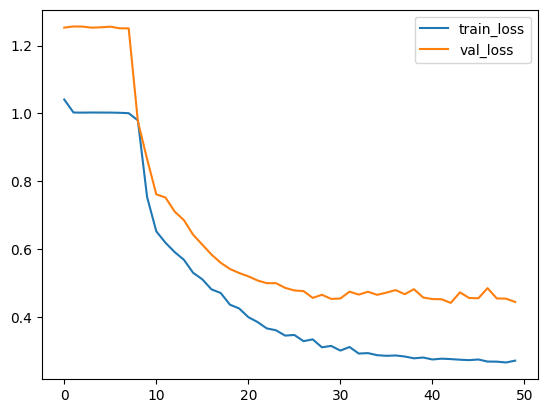

In [ ]:
plt.plot(training_losses, label='train_loss')
plt.plot(validation_losses,label='val_loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    batch_test_losses = []
    test_mae_losses = []

    test_causal_mask = make_causal_mask(vt_batch_size, trg_seq_len).to(device)

    for batch1, batch2 in zip(test_loader, test_loader_date):

        x_test, y_test = batch1
        x_test_date, y_test_date = batch2

        x_test = x_test.to(device)
        y_test = y_test.to(device)

        x_test_date = x_test_date.to(device)
        y_test_date = y_test_date.to(device)

        model.eval()

        test_enc = model.encoder(x_test, x_test_date)

        dec_in = np.zeros((vt_batch_size, horizon, n_features))

        dec_in = torch.from_numpy(dec_in).float()
        dec_in = dec_in.to(device)

        dec_in = torch.cat((x_test[:,-start_token:,:], dec_in), dim = 1)

        dec_in = dec_in.to(device)

        y_test_date = torch.cat((x_test_date[:,-start_token:,:], y_test_date), dim = 1)

        outputs = model.decoder(dec_in, y_test_date, test_enc, test_causal_mask)

        test_output = model.projection(outputs)

        test_output = test_output[:, -horizon:, :]

        t_loss = criterion(test_output, y_test[:,-horizon:,:]).item()
        batch_mae = mae(test_output, y_test[:,-horizon:,:]).item()
        batch_test_losses.append(t_loss)
        test_mae_losses.append(batch_mae)


    test_loss = np.mean(batch_test_losses)
    test_mae = np.mean(test_mae_losses)
    rse_loss = np.sqrt(test_loss)/standard_deviation

    #print(f"[{epoch+1}] Validation loss: {validation_loss:.4f}")

print(f"[{epoch+1}] Test loss: {test_loss:.8f}\t MAE loss:{test_mae:0.8f}\t  RSE loss: {rse_loss:.8f}")

[10] Test loss: 0.61224513	 MAE loss:0.42165401	  RSE loss: 0.70817387


In [ ]:
print(scheduler.get_last_lr())

[0.0001]


In [ ]:
# Define the path for saving the model
save_path = "/content/drive/MyDrive/folder/traffic96.pth"

# Save the model's state_dict to the specified path
torch.save(model.state_dict(), save_path)

# Calculate and print the size of the saved model on disk
import os
model_size = os.path.getsize(save_path)
print(f"Size of the model on disk: {model_size / (1024 * 1024):.2f} MB")

Size of the model on disk: 13.81 MB


In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint.pth'